In [1]:
%load_ext autoreload
%autoreload 2

import util as yu
from util import *
import util_moments as yum

yu.setpath('check_MAstability')

projs=['P0', 'Px', 'Py', 'Pz']
inserts=['tt', 'tx', 'ty', 'tz', 'xx', 'xy', 'xz', 'yy', 'yz', 'zz']

# Conclusion

symmetrization improves stability of model average

uncorrelated fit also improves stability (even more), but can be noisier than correlated fit

In [2]:
ens='d'
enss=[ens]

ens2c2pt={}; ens2moms_2pt={}; ens2c2pt0={}; ens2Njk={}
for ens in enss:
    basepath=f'/p/project1/ngff/li47/code/projectData/05_moments/{yu.ens2full[ens]}/data_merge/'
    path=f'{basepath}disc_2pt.h5'
    with h5py.File(path) as f:
        moms_2pt=yu.moms2list(f['moms'])
        c2pt=yu.jackknife(np.real(f['data/N_N'][:,:,:]))
        
    ens2moms_2pt[ens]=moms_2pt
    ens2c2pt[ens]=c2pt
    ens2c2pt0[ens]=c2pt[:,:,moms_2pt.index([0,0,0])]
    ens2Njk[ens]=len(c2pt)

key2tf2ratio={}
stouts=[10]
js=[f'jg;stout{stout}' for stout in stouts]
for ens in enss:
    path=f'/p/project1/ngff/li47/code/scratch/run/05_moments_run5/{yu.ens2full[ens]}/data_merge/disc_0,0,1,0,0,0.h5'
    with h5py.File(path) as f:
        for jtf in f['data'].keys():
            j,tf=jtf.split('_'); tf=int(tf)
            if j not in js:
                continue        
            key=(ens,j)
            if key not in key2tf2ratio:
                key2tf2ratio[key]={}
            c3pt=yu.jackknife(f['data'][jtf][:,:,0,projs.index('P0'),inserts.index('tz')])
            c2pt=ens2c2pt[ens][:,tf,ens2moms_2pt[ens].index([0,0,1])]
            factor=1/(1j*2*np.pi/yu.ens2NL[ens])
            ratio=np.real(c3pt/c2pt[:,None]*factor)
            key2tf2ratio[key][tf]=ratio
            
ens2tfs_disc={}
for ens in enss:
    tfs=list(key2tf2ratio[(ens,'jg;stout10')].keys()); tfs.sort()
    ens2tfs_disc[ens]=tfs
    print(ens,tfs[0],tfs[-1])

d 2 30


In [3]:
# tfs=range(2,30)
# tf2ratio_CK={}

# path='/p/project1/ngff/kummer3/disconnected/Ratios/D96_Disconnected_gluons_WLS_newRenorm_qsq0.0000_offdiagonal.h5'
# with h5py.File(path) as f:
#     for tf in tfs:
#         t=f[f'qsq0.0000/dt{tf:02d}/10/A20/data'][:]
#         tf2ratio_CK[tf]=t

path=f'/p/project1/ngff/li47/code/projectData/05_moments/tests/tf2ratio_CK_for_check_stability.pkl'
# yu.save_pkl(path,tf2ratio_CK)
tf2ratio_CK=yu.load_pkl(path)

tf2ratio=key2tf2ratio[(ens,'jg;stout10')]

In [22]:
key2fit={}
def run(symmetrizeQ,corrQ):
    gett=lambda t:round(t/yu.ens2a[ens])
    def get_tfs(tmin,tmax,dt=1):
        return range(gett(tmin),gett(tmax),dt)
    lat_a=yu.ens2a[ens]
    tfmins_1st=get_tfs(0.4,1.5)
    tcmins_1st=get_tfs(2*lat_a,0.5)
    
    temp_tf2ratio=yu.cut_tf2ratio(tf2ratio,gett(1.6))
    if symmetrizeQ:
        temp_tf2ratio=yu.symmetrizeRatio(temp_tf2ratio)
    fits_band=yu.doFits_3pt_band(temp_tf2ratio,tcmins_1st,symmetrizeQ=symmetrizeQ,corrQ=corrQ,label=f'{symmetrizeQ}_{corrQ}_band')
    fit_band_WA=yu.doWA_band(fits_band,tf_min=gett(0.8),tf_max=gett(1.3),tcmin=gett(0.2),corrQ=corrQ)
    fits_const=yu.doFits_3pt('const',temp_tf2ratio,tfmins_1st,tcmins_1st,symmetrizeQ=symmetrizeQ,corrQ=corrQ,label=f'{symmetrizeQ}_{corrQ}')
    fit_const_MA=yu.doMA_3pt(fits_const,tfmin_min=gett(0.55),tcmin_min=gett(0.2))
    
    key2fit[(symmetrizeQ,corrQ)]=fit_const_MA

    dic={
        'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[temp_tf2ratio,None,fit_const_MA[-1],None,None],
        'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[None,fit_const_MA,None,None],
        'rainbow:[tfmin,tfmax,tcmin,dt]':[None,16,2,2],
        'mfc:[global]':['None'],
    }

    temp_tf2ratio_CK=yu.cut_tf2ratio(tf2ratio_CK,gett(1.6))
    if symmetrizeQ:
        temp_tf2ratio_CK=yu.symmetrizeRatio(temp_tf2ratio_CK)
    fits_band=yu.doFits_3pt_band(temp_tf2ratio_CK,tcmins_1st,symmetrizeQ=symmetrizeQ,corrQ=corrQ,label=f'{symmetrizeQ}_{corrQ}_band_CK')
    fit_band_WA=yu.doWA_band(fits_band,tf_min=gett(0.8),tf_max=gett(1.3),tcmin=gett(0.2),corrQ=corrQ)
    fits_const_CK=yu.doFits_3pt('const',temp_tf2ratio_CK,tfmins_1st,tcmins_1st,symmetrizeQ=symmetrizeQ,corrQ=corrQ,label=f'{symmetrizeQ}_{corrQ}_CK',overwrite=False)
    fit_const_MA_CK=yu.doMA_3pt(fits_const_CK,tfmin_min=gett(0.55),tcmin_min=gett(0.2))
    
    key2fit[(symmetrizeQ,corrQ,'CK')]=fit_const_MA_CK

    dic2={
        'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[temp_tf2ratio_CK,None,fit_const_MA_CK[-1],None,None],
        'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[None,fit_const_MA_CK,None,None],
        'rainbow:[tfmin,tfmax,tcmin,dt]':[None,16,2,2],
        'mfc:[global]':['white'],
        'shift:[rainbow,midpoint,fit]':[0.1,0.2,0]
    }

    dic2a={
        'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[temp_tf2ratio_CK,None,None,None,None],
        'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[None,None,None,None],
        'rainbow:[tfmin,tfmax,tcmin,dt]':[None,16,2,2],
        'mfc:[global]':['white'],
        'shift:[rainbow,midpoint,fit]':[0.1,0.2,0]
    }

    fig,axs=yu.makePlot_3pt([dic,dic2],shows=['rainbow','midpoint','fit_const'],sharey=True)

    fig,axs=yu.makePlot_3pt(dic2a,shows=['rainbow','midpoint','fit_const'],figAxs=(fig,axs))
    fig.suptitle(f'symmetrizeQ={symmetrizeQ}; corrQ={corrQ}')
    
    axs[0,0].set_ylim([-0.3,1])

    yu.finalizePlot(f'sym_corr={symmetrizeQ}_{corrQ}')

for symmetrizeQ in [True,False]:
    for corrQ in [True,False]:
        run(symmetrizeQ,corrQ)

In [5]:
# correlation
y=np.concatenate([tf2ratio[tf][:,2:-2] for tf in range(4,16)],axis=1)
mean,err,cov=yu.jackmec(y)
print(f'N={y.shape[1]}; CDR={yu.getCDR(cov):.1f}')
y=np.concatenate([(tf2ratio[tf][:,2:tf//2+1]+tf2ratio[tf][:,::-1][:,2:tf//2+1])/2 for tf in range(4,16)],axis=1)
mean,err,cov=yu.jackmec(y)
print(f'N={y.shape[1]}; CDR={yu.getCDR(cov):.1f}; Symmetrized')
print()

tfs=[8,9,10,11,12]
y=np.transpose([tf2ratio[tf][:,tf//2] for tf in tfs])
mean,err,cov=yu.jackmec(y)
rho=yu.cov2correlation(cov)
print(tfs)
print(f'CDR={yu.getCDR(cov):.1f}; rho=')
print(yu.formatMatrix(rho,'>6.2g'))
print()
for tf in [10]:
    mean,err,cov=yu.jackmec(tf2ratio[tf][:,2:-2])
    rho=yu.cov2correlation(cov)
    print(tf)
    print(f'CDR={yu.getCDR(cov):.1f}; rho=')
    print(yu.formatMatrix(rho,'>6.2g'))
    print()


N=78; CDR=56.6
N=42; CDR=51.5; Symmetrized

[8, 9, 10, 11, 12]
CDR=15.2; rho=
     1   0.88   0.66   0.56   0.26
  0.88      1   0.73   0.63   0.29
  0.66   0.73      1   0.87   0.62
  0.56   0.63   0.87      1   0.72
  0.26   0.29   0.62   0.72      1

10
CDR=32.0; rho=
     1   0.82   0.47   0.18  0.022  0.012  0.037
  0.82      1   0.83   0.49   0.18  0.071  0.051
  0.47   0.83      1   0.83   0.47   0.21  0.081
  0.18   0.49   0.83      1   0.82   0.48   0.19
 0.022   0.18   0.47   0.82      1   0.83   0.48
 0.012  0.071   0.21   0.48   0.83      1   0.83
 0.037  0.051  0.081   0.19   0.48   0.83      1



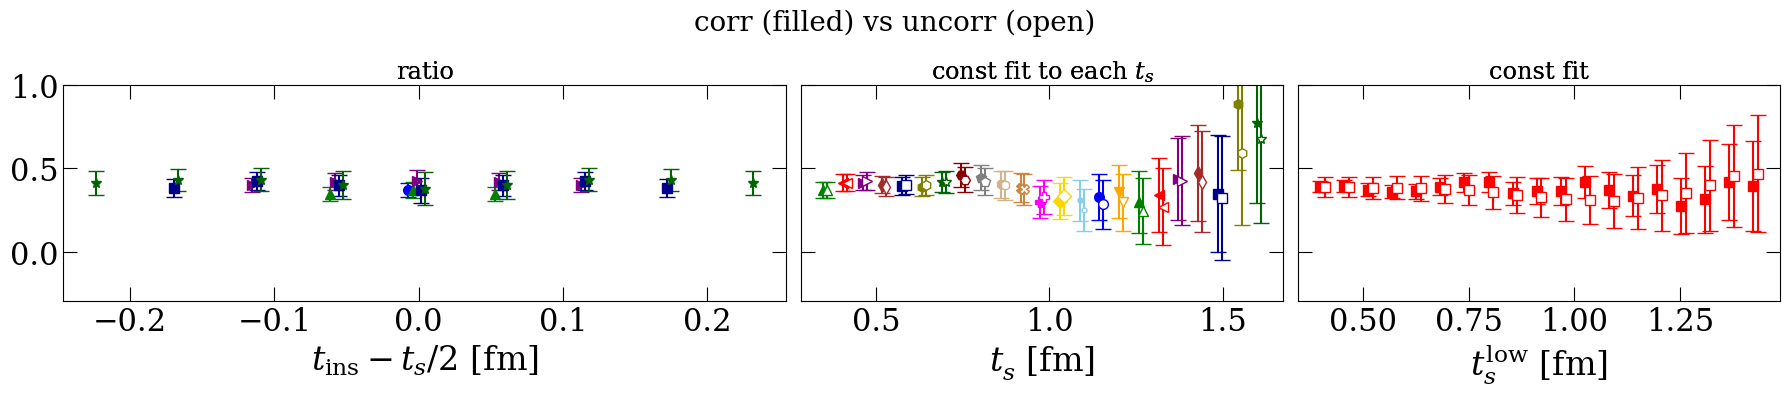

In [23]:
# corr vs uncorr

gett=lambda t:round(t/yu.ens2a[ens])
def get_tfs(tmin,tmax,dt=1):
    return range(gett(tmin),gett(tmax),dt)
lat_a=yu.ens2a[ens]
tfmins_1st=get_tfs(0.4,1.5)
tcmins_1st=get_tfs(2*lat_a,0.5)

symmetrizeQ=True; corrQ=True

temp_tf2ratio=yu.cut_tf2ratio(tf2ratio,gett(1.6))
if symmetrizeQ:
    temp_tf2ratio=yu.symmetrizeRatio(temp_tf2ratio)
fits_band=yu.doFits_3pt_band(temp_tf2ratio,tcmins_1st,symmetrizeQ=symmetrizeQ,corrQ=corrQ,label=f'{symmetrizeQ}_{corrQ}_band')
fit_band_WA=yu.doWA_band(fits_band,tf_min=gett(0.8),tf_max=gett(1.3),tcmin=gett(0.2),corrQ=corrQ)
fits_const=yu.doFits_3pt('const',temp_tf2ratio,tfmins_1st,tcmins_1st,symmetrizeQ=symmetrizeQ,corrQ=corrQ,label=f'{symmetrizeQ}_{corrQ}')
fit_const_MA=yu.doMA_3pt(fits_const,tfmin_min=gett(0.55),tcmin_min=gett(0.2))
dic={
    'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[temp_tf2ratio,fits_band,fits_const,None,None],
    'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[None,None,None,None],
    'rainbow:[tfmin,tfmax,tcmin,dt]':[None,12,2,2],
    'fit_band:[tfmin,tfmax,tcmin_min,tcmin_max,dtf,dtc]':[None,None,3,3,None,None],
    'fit_const:[tfmin_min,tfmin_max,tcmin_min,tcmin_max,dtf,dtc]':[None,None,3,3,None,None],
    'mfc:[global]':['None'],
    'xunit':yu.ens2a[ens]
}

symmetrizeQ=True; corrQ=False

temp_tf2ratio=yu.cut_tf2ratio(tf2ratio,gett(1.6))
if symmetrizeQ:
    temp_tf2ratio=yu.symmetrizeRatio(temp_tf2ratio)
fits_band=yu.doFits_3pt_band(temp_tf2ratio,tcmins_1st,symmetrizeQ=symmetrizeQ,corrQ=corrQ,label=f'{symmetrizeQ}_{corrQ}_band')
fit_band_WA=yu.doWA_band(fits_band,tf_min=gett(0.8),tf_max=gett(1.3),tcmin=gett(0.2),corrQ=corrQ)
fits_const=yu.doFits_3pt('const',temp_tf2ratio,tfmins_1st,tcmins_1st,symmetrizeQ=symmetrizeQ,corrQ=corrQ,label=f'{symmetrizeQ}_{corrQ}')
fit_const_MA=yu.doMA_3pt(fits_const,tfmin_min=gett(0.55),tcmin_min=gett(0.2))
dic2={
    'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[{},fits_band,fits_const,None,None],
    'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[None,None,None,None],
    'rainbow:[tfmin,tfmax,tcmin,dt]':[None,12,2,2],
    'fit_band:[tfmin,tfmax,tcmin_min,tcmin_max,dtf,dtc]':[None,None,3,3,None,None],
    'fit_const:[tfmin_min,tfmin_max,tcmin_min,tcmin_max,dtf,dtc]':[None,None,3,3,None,None],
    'mfc:[global]':['white'],
    'shift:[rainbow,midpoint,fit]':[0.1,0.2,0.2],
    'xunit':yu.ens2a[ens]
}

shows=['rainbow','fit_band','fit_const']
fig,axs=yu.makePlot_3pt([dic],shows=shows,sharey=True)
fig,axs=yu.makePlot_3pt(dic2,shows=shows,sharey=True,figAxs=(fig,axs))

fig.suptitle(f'corr (filled) vs uncorr (open)')

axs[0,0].set_ylim([-0.3,1])

yu.finalizePlot()

0.414(88) vs 0.281(66)
(13, 6), 0.278(68) vs 0.258(65), chi2=244.1 vs 216.8, chi2R=1.6 vs 1.4, prob=0% vs 64%
(14, 6), 0.299(72) vs 0.266(70), chi2=243.2 vs 215.6, chi2R=1.6 vs 1.4, prob=0% vs 16%
(14, 7), 0.399(86) vs 0.405(83), chi2=166.3 vs 157.0, chi2R=1.4 vs 1.3, prob=53% vs 7%
(15, 6), 0.301(79) vs 0.273(76), chi2=242.2 vs 212.5, chi2R=1.7 vs 1.5, prob=0% vs 3%
(15, 7), 0.369(92) vs 0.375(90), chi2=165.6 vs 156.3, chi2R=1.4 vs 1.3, prob=28% vs 4%
(16, 6), 0.323(87) vs 0.303(84), chi2=236.2 vs 206.2, chi2R=1.7 vs 1.5, prob=0% vs 1%
(16, 7), 0.408(99) vs 0.391(96), chi2=164.5 vs 156.0, chi2R=1.4 vs 1.3, prob=6% vs 0%
(16, 8), 0.60(12) vs 0.53(11), chi2=111.4 vs 102.7, chi2R=1.2 vs 1.1, prob=11% vs 1%


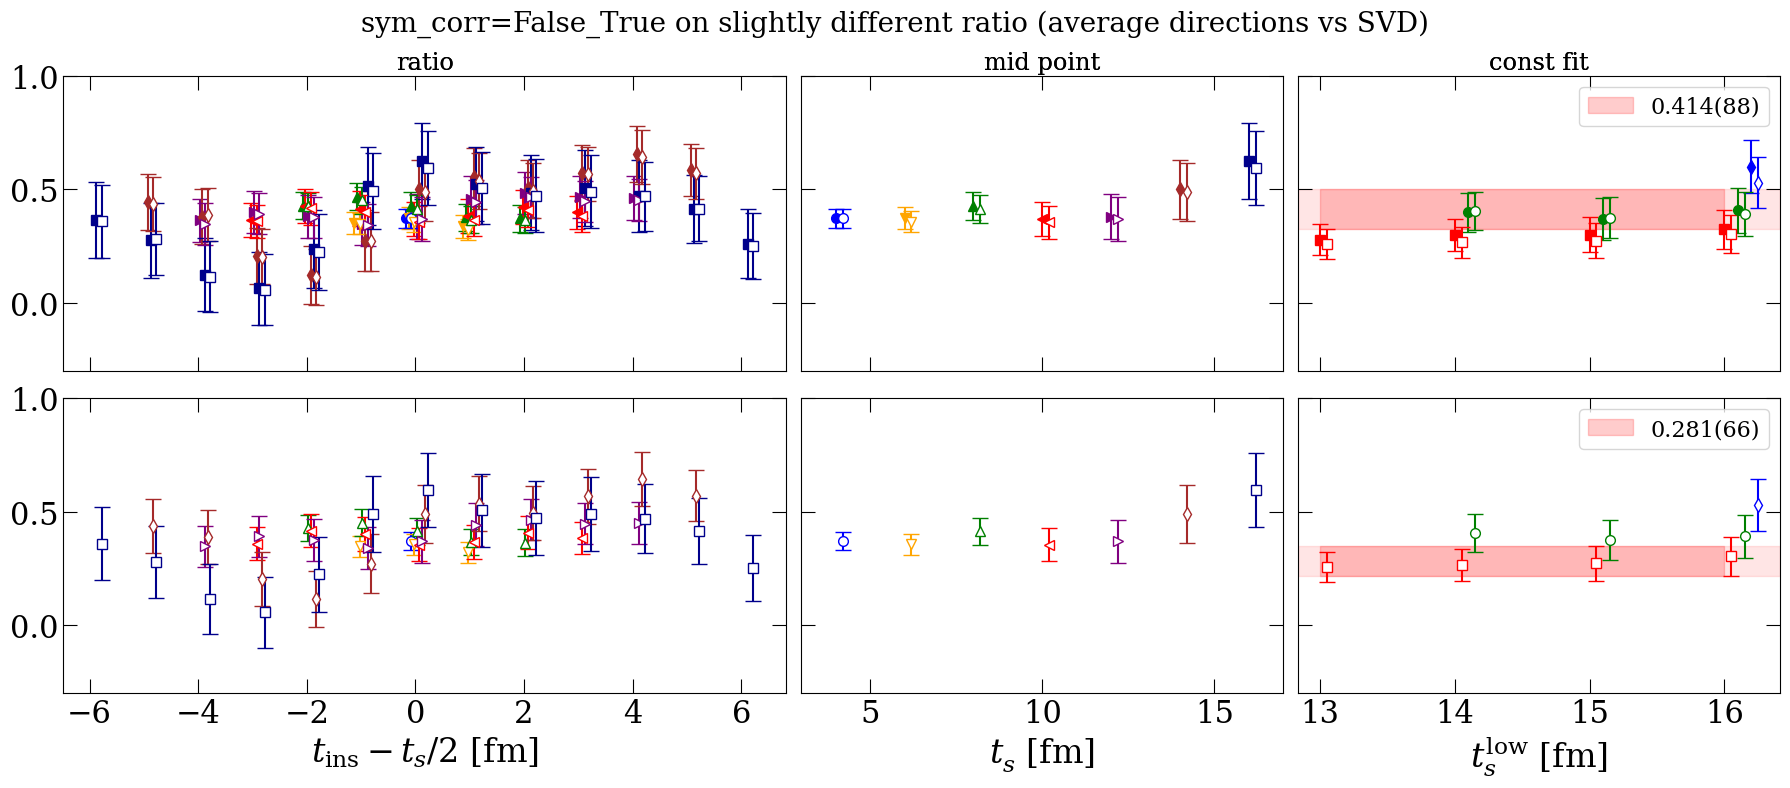

In [33]:
symmetrizeQ=False; corrQ=True
fits_const=yu.getFits(label=f'{symmetrizeQ}_{corrQ}')
fit_const_MA=yu.doMA_3pt(fits_const,tfmin_min=13,tfmin_max=16,tcmin_min=6,tcmin_max=8)
pars_jk,probs_jk,fits=fit_const_MA

temp_tf2ratio=yu.cut_tf2ratio(tf2ratio,gett(1.6))
if symmetrizeQ:
    temp_tf2ratio=yu.symmetrizeRatio(temp_tf2ratio)
dic={
    'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[temp_tf2ratio,None,fits,None,None],
    'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[None,fit_const_MA,None,None],
    'rainbow:[tfmin,tfmax,tcmin,dt]':[None,16,2,2],
    'mfc:[global]':['None'],
}

fits_const_CK=yu.getFits(label=f'{symmetrizeQ}_{corrQ}_CK')
fit_const_MA_CK=yu.doMA_3pt(fits_const_CK,tfmin_min=13,tfmin_max=16,tcmin_min=6,tcmin_max=8)
pars_jk_CK,probs_jk_CK,fits_CK=fit_const_MA_CK

temp_tf2ratio_CK=yu.cut_tf2ratio(tf2ratio_CK,gett(1.6))
if symmetrizeQ:
    temp_tf2ratio_CK=yu.symmetrizeRatio(temp_tf2ratio_CK)
dic2={
    'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[temp_tf2ratio_CK,None,fits_CK,None,None],
    'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[None,fit_const_MA_CK,None,None],
    'rainbow:[tfmin,tfmax,tcmin,dt]':[None,16,2,2],
    'mfc:[global]':['white'],
    'shift:[rainbow,midpoint,fit]':[0.1,0.2,0.1/2]
}
dic2a={
    'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[temp_tf2ratio_CK,None,fits_CK,None,None],
    'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[None,None,None,None],
    'rainbow:[tfmin,tfmax,tcmin,dt]':[None,16,2,2],
    'mfc:[global]':['white'],
    'shift:[rainbow,midpoint,fit]':[0.1,0.2,0.1/2]
}

shows=['rainbow','midpoint','fit_const']
fig,axs=yu.makePlot_3pt([dic,dic2],shows=shows,sharey=True)
fig,axs=yu.makePlot_3pt(dic2a,shows=shows,figAxs=(fig,axs))
fig.suptitle(f'sym_corr={symmetrizeQ}_{corrQ} on slightly different ratio (average directions vs SVD)')

axs[0,0].set_ylim([-0.3,1])
yu.finalizePlot()

print(yu.jackme_un2str(pars_jk[:,0]),'vs',yu.jackme_un2str(pars_jk_CK[:,0]))

probs1=np.mean(probs_jk,axis=0)
probs2=np.mean(probs_jk_CK,axis=0)

for ifit,(fit1,fit2) in enumerate(zip(fits,fits_CK)):
    fitlabel1,pars_jk1,chi2_jk1,Ndof1=fit1
    fitlabel2,pars_jk2,chi2_jk2,Ndof2=fit2
    assert(fitlabel1==fitlabel2 and Ndof1==Ndof2)
    chi2_1=np.mean(chi2_jk1); chi2_2=np.mean(chi2_jk2)
    print(f'{fitlabel1}, {yu.jackme_un2str(pars_jk1[:,0])} vs {yu.jackme_un2str(pars_jk2[:,0])}, chi2={chi2_1:.1f} vs {chi2_2:.1f},'+\
        f' chi2R={chi2_1/Ndof1:.1f} vs {chi2_2/Ndof2:.1f}, prob={int(100*probs1[ifit]):d}% vs {int(100*probs2[ifit]):d}%')

0.295(89) vs 0.322(95)
(13, 6), 0.250(85) vs 0.228(82), chi2=124.0 vs 118.6, chi2R=1.6 vs 1.5, prob=41% vs 22%
(14, 6), 0.263(88) vs 0.238(86), chi2=123.7 vs 118.4, chi2R=1.6 vs 1.5, prob=17% vs 8%
(14, 7), 0.36(11) vs 0.37(11), chi2=93.7 vs 85.7, chi2R=1.5 vs 1.4, prob=17% vs 35%
(15, 6), 0.280(94) vs 0.257(92), chi2=121.0 vs 114.8, chi2R=1.6 vs 1.5, prob=8% vs 7%
(15, 7), 0.35(12) vs 0.36(11), chi2=93.4 vs 85.4, chi2R=1.5 vs 1.4, prob=7% vs 15%
(16, 6), 0.31(10) vs 0.288(100), chi2=120.4 vs 113.6, chi2R=1.6 vs 1.5, prob=1% vs 1%
(16, 7), 0.36(12) vs 0.36(12), chi2=93.3 vs 85.4, chi2R=1.5 vs 1.4, prob=2% vs 5%
(16, 8), 0.59(15) vs 0.54(14), chi2=67.4 vs 60.2, chi2R=1.4 vs 1.3, prob=2% vs 3%


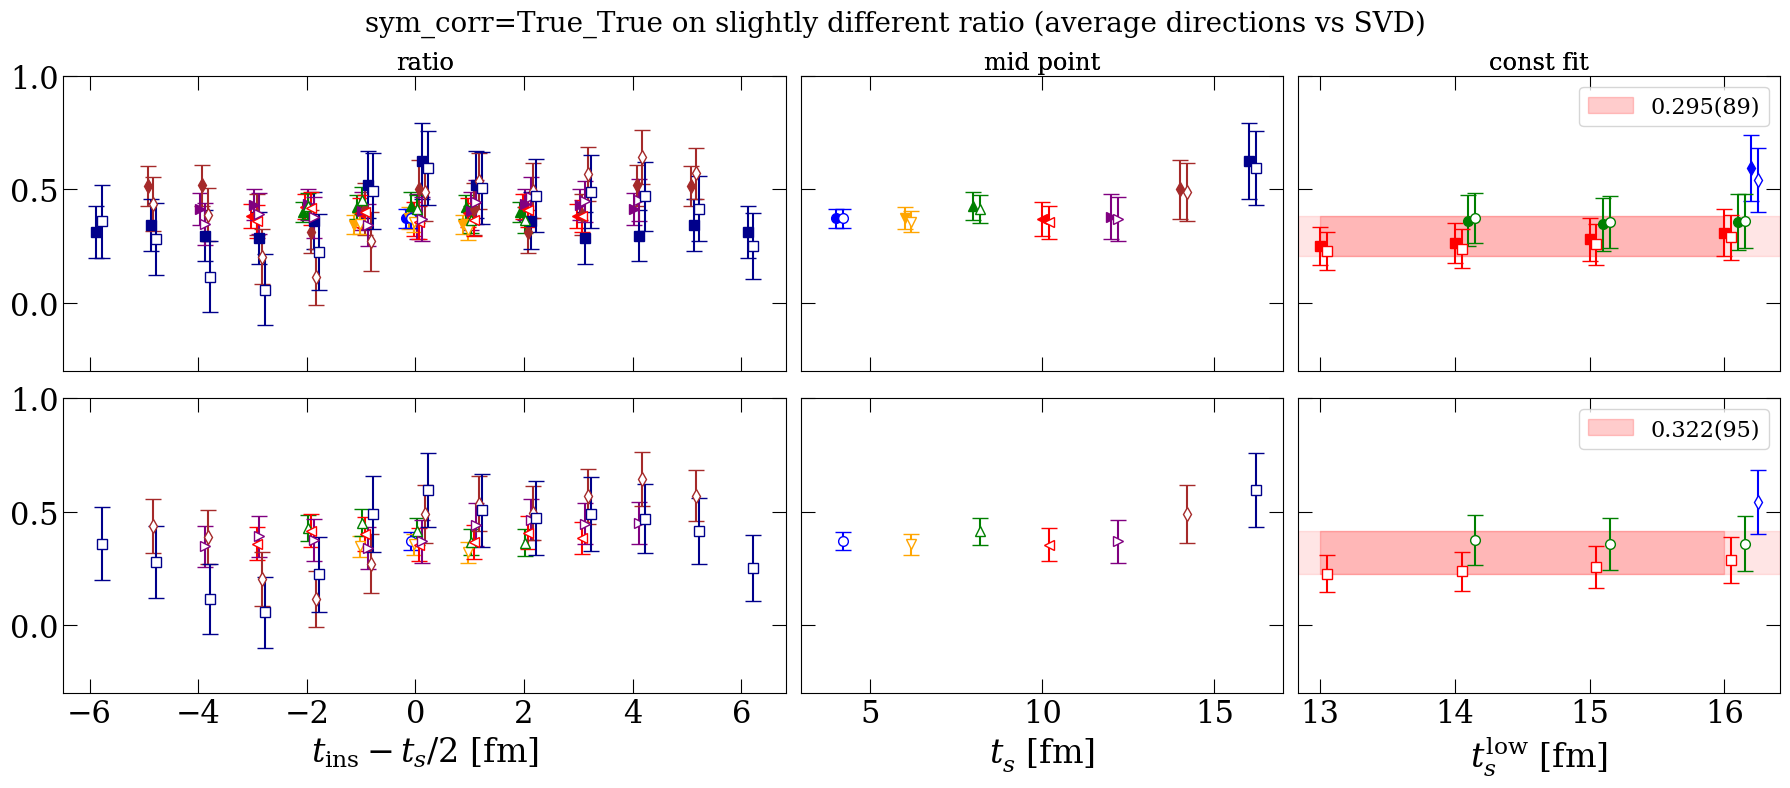

In [25]:
symmetrizeQ=True; corrQ=True
fits_const=yu.getFits(label=f'{symmetrizeQ}_{corrQ}')
fit_const_MA=yu.doMA_3pt(fits_const,tfmin_min=13,tfmin_max=16,tcmin_min=6,tcmin_max=8)
pars_jk,probs_jk,fits=fit_const_MA

temp_tf2ratio=yu.cut_tf2ratio(tf2ratio,gett(1.6))
if symmetrizeQ:
    temp_tf2ratio=yu.symmetrizeRatio(temp_tf2ratio)
dic={
    'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[temp_tf2ratio,None,fits,None,None],
    'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[None,fit_const_MA,None,None],
    'rainbow:[tfmin,tfmax,tcmin,dt]':[None,16,2,2],
    'mfc:[global]':['None'],
}

fits_const_CK=yu.getFits(label=f'{symmetrizeQ}_{corrQ}_CK')
fit_const_MA_CK=yu.doMA_3pt(fits_const_CK,tfmin_min=13,tfmin_max=16,tcmin_min=6,tcmin_max=8)
pars_jk_CK,probs_jk_CK,fits_CK=fit_const_MA_CK

temp_tf2ratio_CK=yu.cut_tf2ratio(tf2ratio_CK,gett(1.6))
if symmetrizeQ:
    temp_tf2ratio=yu.symmetrizeRatio(temp_tf2ratio)
dic2={
    'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[temp_tf2ratio_CK,None,fits_CK,None,None],
    'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[None,fit_const_MA_CK,None,None],
    'rainbow:[tfmin,tfmax,tcmin,dt]':[None,16,2,2],
    'mfc:[global]':['white'],
    'shift:[rainbow,midpoint,fit]':[0.1,0.2,0.1/2]
}
dic2a={
    'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[temp_tf2ratio_CK,None,fits_CK,None,None],
    'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[None,None,None,None],
    'rainbow:[tfmin,tfmax,tcmin,dt]':[None,16,2,2],
    'mfc:[global]':['white'],
    'shift:[rainbow,midpoint,fit]':[0.1,0.2,0.1/2]
}

shows=['rainbow','midpoint','fit_const']
fig,axs=yu.makePlot_3pt([dic,dic2],shows=shows,sharey=True)
fig,axs=yu.makePlot_3pt(dic2a,shows=shows,figAxs=(fig,axs))
fig.suptitle(f'sym_corr={symmetrizeQ}_{corrQ} on slightly different ratio (average directions vs SVD)')

axs[0,0].set_ylim([-0.3,1])
yu.finalizePlot()

print(yu.jackme_un2str(pars_jk[:,0]),'vs',yu.jackme_un2str(pars_jk_CK[:,0]))

probs1=np.mean(probs_jk,axis=0)
probs2=np.mean(probs_jk_CK,axis=0)

for ifit,(fit1,fit2) in enumerate(zip(fits,fits_CK)):
    fitlabel1,pars_jk1,chi2_jk1,Ndof1=fit1
    fitlabel2,pars_jk2,chi2_jk2,Ndof2=fit2
    assert(fitlabel1==fitlabel2 and Ndof1==Ndof2)
    chi2_1=np.mean(chi2_jk1); chi2_2=np.mean(chi2_jk2)
    print(f'{fitlabel1}, {yu.jackme_un2str(pars_jk1[:,0])} vs {yu.jackme_un2str(pars_jk2[:,0])}, chi2={chi2_1:.1f} vs {chi2_2:.1f},'+\
        f' chi2R={chi2_1/Ndof1:.1f} vs {chi2_2/Ndof2:.1f}, prob={int(100*probs1[ifit]):d}% vs {int(100*probs2[ifit]):d}%')

0.40(14) vs 0.38(13)
(13, 6), 0.40(13) vs 0.39(13), chi2=47.7 vs 48.9, chi2R=0.6 vs 0.6, prob=68% vs 68%
(14, 6), 0.40(14) vs 0.39(13), chi2=47.7 vs 48.9, chi2R=0.6 vs 0.6, prob=25% vs 25%
(14, 7), 0.46(17) vs 0.44(16), chi2=30.8 vs 31.0, chi2R=0.5 vs 0.5, prob=0% vs 0%
(15, 6), 0.40(15) vs 0.38(14), chi2=47.1 vs 48.1, chi2R=0.6 vs 0.6, prob=4% vs 4%
(15, 7), 0.46(17) vs 0.44(17), chi2=30.7 vs 30.9, chi2R=0.5 vs 0.5, prob=0% vs 0%
(16, 6), 0.39(16) vs 0.37(15), chi2=46.2 vs 47.2, chi2R=0.6 vs 0.6, prob=0% vs 1%
(16, 7), 0.46(18) vs 0.43(18), chi2=30.5 vs 30.6, chi2R=0.5 vs 0.5, prob=0% vs 0%
(16, 8), 0.48(22) vs 0.45(21), chi2=23.5 vs 23.9, chi2R=0.5 vs 0.5, prob=0% vs 0%


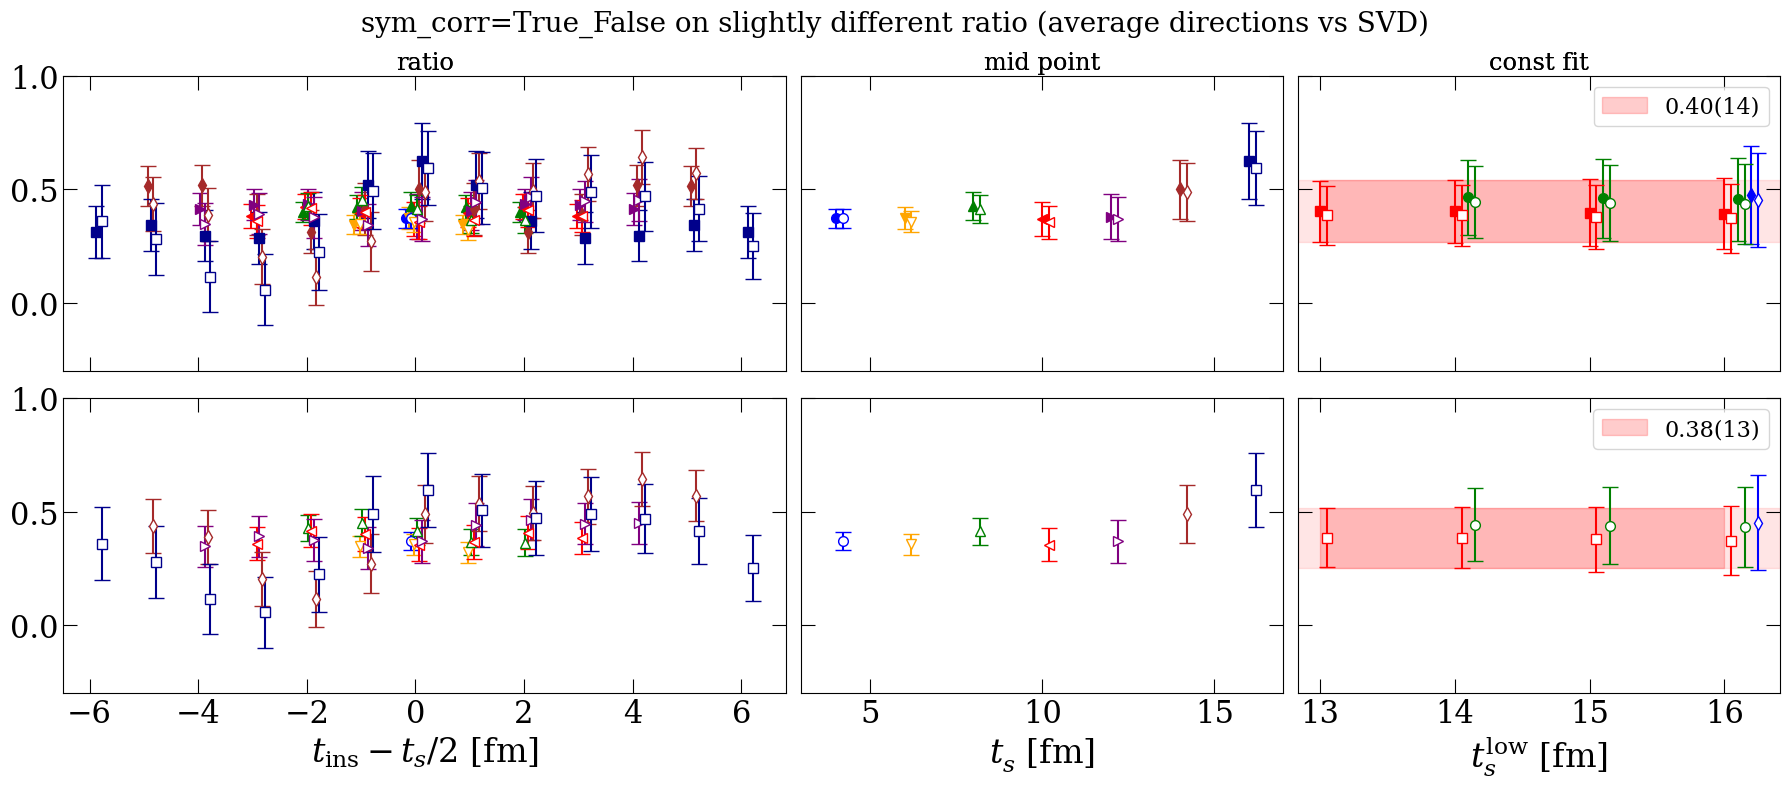

In [27]:
symmetrizeQ=True; corrQ=False
fits_const=yu.getFits(label=f'{symmetrizeQ}_{corrQ}')
fit_const_MA=yu.doMA_3pt(fits_const,tfmin_min=13,tfmin_max=16,tcmin_min=6,tcmin_max=8)
pars_jk,probs_jk,fits=fit_const_MA

temp_tf2ratio=yu.cut_tf2ratio(tf2ratio,gett(1.6))
if symmetrizeQ:
    temp_tf2ratio=yu.symmetrizeRatio(temp_tf2ratio)
dic={
    'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[temp_tf2ratio,None,fits,None,None],
    'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[None,fit_const_MA,None,None],
    'rainbow:[tfmin,tfmax,tcmin,dt]':[None,16,2,2],
    'mfc:[global]':['None'],
}

fits_const_CK=yu.getFits(label=f'{symmetrizeQ}_{corrQ}_CK')
fit_const_MA_CK=yu.doMA_3pt(fits_const_CK,tfmin_min=13,tfmin_max=16,tcmin_min=6,tcmin_max=8)
pars_jk_CK,probs_jk_CK,fits_CK=fit_const_MA_CK

temp_tf2ratio_CK=yu.cut_tf2ratio(tf2ratio_CK,gett(1.6))
if symmetrizeQ:
    temp_tf2ratio=yu.symmetrizeRatio(temp_tf2ratio)
dic2={
    'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[temp_tf2ratio_CK,None,fits_CK,None,None],
    'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[None,fit_const_MA_CK,None,None],
    'rainbow:[tfmin,tfmax,tcmin,dt]':[None,16,2,2],
    'mfc:[global]':['white'],
    'shift:[rainbow,midpoint,fit]':[0.1,0.2,0.1/2]
}
dic2a={
    'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[temp_tf2ratio_CK,None,fits_CK,None,None],
    'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[None,None,None,None],
    'rainbow:[tfmin,tfmax,tcmin,dt]':[None,16,2,2],
    'mfc:[global]':['white'],
    'shift:[rainbow,midpoint,fit]':[0.1,0.2,0.1/2]
}

shows=['rainbow','midpoint','fit_const']
fig,axs=yu.makePlot_3pt([dic,dic2],shows=shows,sharey=True)
fig,axs=yu.makePlot_3pt(dic2a,shows=shows,figAxs=(fig,axs))
fig.suptitle(f'sym_corr={symmetrizeQ}_{corrQ} on slightly different ratio (average directions vs SVD)')

axs[0,0].set_ylim([-0.3,1])
yu.finalizePlot()

print(yu.jackme_un2str(pars_jk[:,0]),'vs',yu.jackme_un2str(pars_jk_CK[:,0]))

probs1=np.mean(probs_jk,axis=0)
probs2=np.mean(probs_jk_CK,axis=0)

for ifit,(fit1,fit2) in enumerate(zip(fits,fits_CK)):
    fitlabel1,pars_jk1,chi2_jk1,Ndof1=fit1
    fitlabel2,pars_jk2,chi2_jk2,Ndof2=fit2
    assert(fitlabel1==fitlabel2 and Ndof1==Ndof2)
    chi2_1=np.mean(chi2_jk1); chi2_2=np.mean(chi2_jk2)
    print(f'{fitlabel1}, {yu.jackme_un2str(pars_jk1[:,0])} vs {yu.jackme_un2str(pars_jk2[:,0])}, chi2={chi2_1:.1f} vs {chi2_2:.1f},'+\
        f' chi2R={chi2_1/Ndof1:.1f} vs {chi2_2/Ndof2:.1f}, prob={int(100*probs1[ifit]):d}% vs {int(100*probs2[ifit]):d}%')